In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pybedtools
import random
from scipy.stats import zscore
from statsmodels.stats.multitest import multipletests
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'

In [2]:
MANE = pd.read_csv('MANE.GRCh38.v1.3.summary.txt', sep='\t')
MANE.rename(columns={'symbol': 'gene'}, inplace=True)
MANE['chr'] = 'chr' + MANE['GRCh38_chr'].str.extract(r'(NC_\d+)').squeeze().str.extract(r'NC_0*(\d+)')
MANE['length'] = abs(MANE['chr_start'] - MANE['chr_end'])
MANE['chr'] = MANE['chr'].replace({'chr23': 'chrX', 'chr24': 'chrY'})
MANE = MANE.dropna(subset=['chr'])
MANE = MANE.drop(columns=['RefSeq_nuc',
 'RefSeq_prot',
 'Ensembl_nuc',
 'Ensembl_prot',
 'MANE_status']).drop_duplicates()
genes = MANE[['gene', 'chr', 'chr_start', 'chr_end']].drop_duplicates()

In [3]:
annotated_BREACHES = pd.read_csv('./annotated_BREACHES.bed', sep='\t', header=None, names=['chr', 'start', 'end', 'coverage'])

filtered_genes = pd.merge(
    genes,
    annotated_BREACHES,
    on='chr',  
)

filtered_genes = filtered_genes[
    (filtered_genes['chr_start'] >= filtered_genes['start']) &
    (filtered_genes['chr_end'] <= filtered_genes['end'])
]

filtered_genes = filtered_genes[['chr', 'chr_start', 'chr_end', 'gene']]

In [4]:
bed_files = [f for f in os.listdir('./RSEG') if f.endswith('_BREACHes.bed')]

regions = {
    "gene_body": lambda row: (row['chr_start'], row['chr_end']),  # Entire gene body
    "promoter_10kb": lambda row: (row['chr_start'] - 2000, row['chr_start'] + 10000),  
}

result_df = filtered_genes[['gene', 'chr', 'chr_start', 'chr_end']].copy()
result_df[['gene_body', 'promoter_10kb']] = 0  # Add columns for regions

for bed_file in bed_files:
    bed_path = os.path.join('./RSEG', bed_file)
    
    # Load the BED file
    bed_df = pd.read_csv(bed_path, sep='\t', header=None, names=['chr', 'start', 'end'])
    
    for region_name, region_func in regions.items():
        # Iterate over each row in the result_df
        for idx, gene_row in result_df.iterrows():
            chr_gene = gene_row['chr']
            start_region, end_region = region_func(gene_row)  # Calculate region boundaries
            
            # Filter the BED file to get rows that match the same chromosome
            bed_chr = bed_df[bed_df['chr'] == chr_gene]
            
            for _, bed_row in bed_chr.iterrows():
                # Calculate overlap
                overlap_start = max(start_region, bed_row['start'])
                overlap_end = min(end_region, bed_row['end'])
                overlap_length = max(0, overlap_end - overlap_start)
                
                # Check if overlap is at least 90% of the region length
                region_length = end_region - start_region
                if overlap_length >= 0.9 * region_length:
                    result_df.at[idx, region_name] += 1
final_df = result_df[['gene', 'gene_body', 'promoter_10kb']].query('promoter_10kb > 0')

In [5]:
genes_brain_CV = pd.read_csv('./genes_brain_CV.txt', sep ='\t', index_col=False)
genes_brain_CV['BRAIN_BREACH'] = genes_brain_CV['gene'].isin(final_df['gene'])

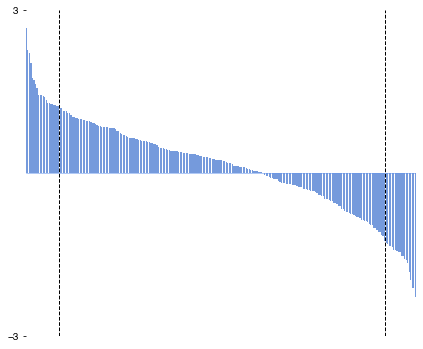

In [6]:
plt.figure(figsize=(7, 6))
breach_data = genes_brain_CV.query('BRAIN_BREACH == True').sort_values('cv_FXS_zscore', ascending = False)

bar = sns.barplot(
    data=breach_data, 
    x='gene', y='cv_FXS_zscore', width=0.8, color='cornflowerblue'
)
bar.spines[:].set_visible(False)

plt.axvline(x='BCAP29', 
            color='k', linestyle='--', linewidth=1)
plt.axvline(x='TEX26', 
            color='k', linestyle='--', linewidth=1)

plt.axhline(y=0, 
            color='cornflowerblue', linewidth=0.5)

plt.xticks([])

plt.xlabel('')
plt.ylabel('')
plt.ylim(-3, 3)
plt.yticks([-3, 3])

#bar.figure.savefig('BRAIN_BREACH_genes_het_brain_ticked.pdf', dpi=1000)
plt.show()

In [7]:
sfari = pd.read_csv('SFARI-Gene_genes_01-13-2025release_01-15-2025export.csv')

In [8]:
genes_sfari = genes_brain_CV.merge(sfari, left_on='gene', right_on='gene-symbol', how='left')

In [9]:
breach_data_sfari = genes_sfari.query('BRAIN_BREACH == True')

5
10
2


/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_54533/990128391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breach_data_sfari['cv_group'] = pd.cut(


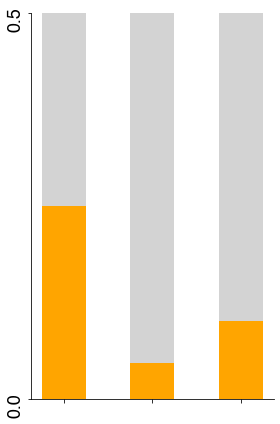

In [10]:
breach_data_sfari['cv_group'] = pd.cut(
    breach_data_sfari['cv_FXS_zscore'],
    bins=[-float('inf'), -1.25, 1.25, float('inf')],
    labels=['< -1.25', '>= -1.25 & <= 1.25', '> 1.25']
)

proportions = {'cv_group': [], 'either': [], 'neither': []}

for group in breach_data_sfari['cv_group'].unique():
    group_data = breach_data_sfari[breach_data_sfari['cv_group'] == group]
    total = len(group_data)
    if total > 0:
        either_count = ((group_data['gene-score'] < 3) | (group_data['syndromic'] == 1)).sum()
        print(either_count)
        neither_count = total - either_count
        proportions['cv_group'].append(group)
        proportions['either'].append(either_count / total)
        proportions['neither'].append(neither_count / total)
    else:
        proportions['cv_group'].append(group)
        proportions['either'].append(0)
        proportions['neither'].append(0)

proportions_df = pd.DataFrame(proportions)

fig, ax = plt.subplots(figsize=(4, 6))
bar_width = 0.5
x = range(len(proportions_df))

ax.bar(x, proportions_df['either'], width=bar_width, label='Either gene-score or syndromic < 3', color='orange')
ax.bar(x, proportions_df['neither'], width=bar_width, bottom=proportions_df['either'], label='Neither', color='lightgrey')
ax.set_xticks(x)
ax.set_xticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(0, 0.4)
plt.yticks([0, 0.5], rotation=90, fontsize=18)
plt.tight_layout()

#plt.savefig('sfari_S12.pdf', dpi=1000)
plt.show()

In [11]:
filtered_df = genes_sfari[(genes_sfari['BRAIN_BREACH'] == False)]
random.seed('girlsoconfusing')
empirical_samples = []
for _ in range(10000):
    sample = filtered_df.sample(n=20, replace=False)
    proportion = len(sample[(sample['gene-score'] < 3) | (sample['syndromic'] == 1)]) / 20
    empirical_samples.append(proportion)

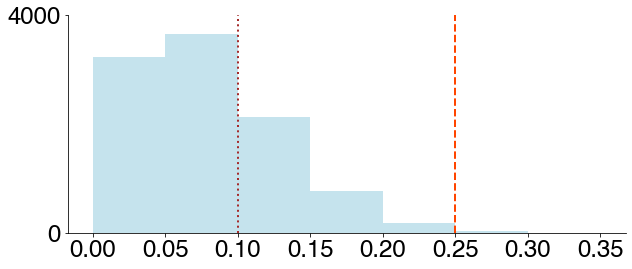

Empirical p-value for mosaic BREACH genes: 0.0036
Empirical p-value for invariant BREACH genes: 0.3114


In [17]:
# Step 2: Analyze proportions for BRAIN_BREACH == True
high_zscore = genes_sfari[(genes_sfari['BRAIN_BREACH'] == True) & 
                          (genes_sfari['cv_FXS_zscore'] > 1.25)]
low_zscore = genes_sfari[(genes_sfari['BRAIN_BREACH'] == True) & 
                         (genes_sfari['cv_FXS_zscore'] < -1.25)]

high_proportion = len(high_zscore[(high_zscore['gene-score'] < 3) | (high_zscore['syndromic'] == 1)]) / len(high_zscore)
low_proportion = len(low_zscore[(low_zscore['gene-score'] < 3) | (low_zscore['syndromic'] == 1)]) / len(low_zscore)

fig, ax = plt.subplots(figsize=(10, 4))

plt.hist(empirical_samples, bins=7 ,color='lightblue', alpha=0.7, label='10,000 draws of 20 non-BREACH genes')
plt.axvline(high_proportion, color='orangered', linestyle='--', linewidth=2, label='mosaic BREACH genes, N=20')
plt.axvline(low_proportion, color='brown', linestyle=':', linewidth=2, label='invariant BREACH genes, N=20')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.yticks([0,4000], fontsize=24)
plt.xticks(fontsize=24)

plt.savefig('sfari_S12_histogram.pdf', dpi=1000)
plt.show()

high_pvalue = np.mean(np.array(empirical_samples) >= high_proportion)
low_pvalue = np.mean(np.array(empirical_samples) >= low_proportion)

print(f"Empirical p-value for mosaic BREACH genes: {high_pvalue}")
print(f"Empirical p-value for invariant BREACH genes: {low_pvalue}")